In [114]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from typing import Optional, Tuple, Callable, Union, List
import numpy as np
import numpy.typing as npt
import scipy.special as scisp
from fireworks.nbodylib.nunits import Nbody_units
from fireworks.nbodylib.potentials import Potential_Base, MultiPotential, Point_Mass
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_leapfrog_galaxy, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [115]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# Slicing the dataframe to reduce computation time
num_particles = int(1e3)
df = df_0.iloc[:num_particles]

#I create a class with the mass, pos, vel of each element of the Galaxy
masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
# reshape mass array to 1D array (required by pyfalcon)
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
#I can do the same for the other Galaxy. This second galaxy is the same as the first one, but translated by a certain value. In particular I have
pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

#So, I just apply this translation to find the second galaxy
positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

# POTENTIAS (TRIAL)

We will now try to add some potentials to our system, in order to make it more realistic. In particular, we implemented three potentials in the 
`potentials` subpackage of the `Fireworks` package. \
These potentials are: 

1) NAVARRO-FRENK-WHITE POTENTIAL (NFW)
This potential is used for the DM halo. \
The formula is the following:
\begin{gather}
    \vec{a} = -\frac{G  M_{\text{vir}}}{r^3 \cdot (a+r)  \delta_c} \left[ (a+r)  \ln\left(1 + \frac{r}{a}\right) - r \right]  \vec{r} \\
    \Phi = -\frac{G M_{\text{vir}} \ln\left(1 + \frac{r}{a}\right)}{r \delta_c}
\end{gather}
The typical values for the constants for the MW galaxy are (from the slides) $M_{vir} = 8 \cdot 10^{11} M_\odot$, $a = 16$ kpc, $c = 15.3$ .


ADD OTHERS


# Trials

In [116]:
# firts of all we need to put the scales of the system
Mscale = 1e10                                   # mass scale
Lscale = 1e3                                    # length scale
nu = Nbody_units(M=Mscale, L=Lscale)            # create the unit system

pos_phy = nu.pos_to_physical(Galaxy1.pos)       # convert positions to physical units 
vel_phy = nu.vel_to_physical(Galaxy1.vel)       # convert velocities to physical units
mass_phy = nu.m_to_physical(Galaxy1.mass)       # convert masses to physical units

Galaxy1_phy = Particles(pos_phy, vel_phy, mass_phy)     # create the physical galaxy


### Definitions

In [117]:
class Potential_Base:

    def __init__(self):
        pass

    def acceleration(self, particles: Particles, softening: float = 0.) \
            -> Tuple[npt.NDArray[np.float64],Optional[npt.NDArray[np.float64]],Optional[npt.NDArray[np.float64]]]:

            return self._acceleration(particles)

    def evaluate(self,R,z=0, softening=0):

        R=np.atleast_1d(R)
        z=np.atleast_1d(z)

        pos=np.zeros(shape=(len(R),3))
        if len(R)==1:
            pos[:,0]=R[0]
        else:
            pos[:,0]=R

        if len(z)==1:
            pos[:,2]=z[0]
        else:
            pos[:,2]=z

        vel = np.zeros_like(pos)
        mass = np.zeros(len(R))

        part=Particles(position=pos, velocity=vel, mass=mass)

        return self.acceleration(part,softening)

    def _acceleration(self, particles: Particles, softening: float = 0.) \
            -> Tuple[npt.NDArray[np.float64],Optional[npt.NDArray[np.float64]],Optional[npt.NDArray[np.float64]]]:
        """
        Estimate the acceleration (and optionally the jerk and the potential)

        :param particles: An instance of the class Particles
        :param softening: Softening parameter
        :return: A tuple with 3 elements:

            - acc, Nx3 numpy array storing the acceleration for each particle
            - jerk, Nx3 numpy array storing the time derivative of the acceleration, can be set to None
            - pot, Nx1 numpy array storing the potential at each particle position, can be set to None

        """
        raise NotImplementedError("This method should be implemented in a derived class")
        

In [118]:

class Hernquist2(Potential_Base):

    def __init__(self,Mass: float, a: float):

        self.Mass = Mass
        self.a = a

    def _acceleration(self, particles: Particles, softening: float = 0.) \
            -> Tuple[npt.NDArray[np.float64],Optional[npt.NDArray[np.float64]],Optional[npt.NDArray[np.float64]]]:

        # fist of all we need to put the scales of the system, and convert everything to physical units
        Mscale = 1e10                                   # mass scale
        Lscale = 1e3                                    # length scale
        nu = Nbody_units(M=Mscale, L=Lscale)            # create the unit system

        pos_phy = nu.pos_to_physical(Galaxy1.pos)       # convert positions to physical units 
        vel_phy = nu.vel_to_physical(Galaxy1.vel)       # convert velocities to physical units
        mass_phy = nu.m_to_physical(Galaxy1.mass)       # convert masses to physical units
        Galaxy1_phy = Particles(pos_phy, vel_phy, mass_phy)     # create the physical galaxy

        # then i can calculate the acceleration and the potential
        r  = particles.radius()
        reff = r+self.a
        acc = -self.Mass / (reff * reff) * (particles.pos/r)
        pot = -self.Mass/reff

        # and finally i can convert everything back to n-body units
        acc = nu.vel_to_Nbody(acc)                      #convert acceleration to n-body units
        pot = nu.m_to_Nbody(pot)                     #convert potential to n-body units

        return acc,None,pot
    

def Hernquist2_acceleration(particles: Particles, softening: float = 0.) \
        -> Tuple[npt.NDArray[np.float64], Optional[npt.NDArray[np.float64]], Optional[npt.NDArray[np.float64]]]:
    # Create an instance of the Hernquist2 potential
    pot = Hernquist2(Mass, a)

    # Calculate acceleration and potential using Hernquist2
    acc, jerk, potential = pot._acceleration(particles, softening)

    # Ensure potential is a 1D array
    potential = np.atleast_1d(potential)

    # Reshape potential to (N,) if needed
    if potential.ndim > 1:
        potential = potential.flatten()

    return acc, jerk, potential


In [119]:
def integrator_leapfrog(particles: Particles,
                        tstep: float,
                        acceleration_estimator: Union[Callable, List],
                        softening: float = 0.,
                        external_accelerations: Optional[List] = None):

    acc, jerk, potential = acceleration_estimator(particles, softening)

    # Check additional accelerations
    if external_accelerations is not None:
        for ext_acc_estimator in external_accelerations:
            acct, jerkt, potentialt = ext_acc_estimator(particles, softening)
            acc += acct
            if jerk is not None and jerkt is not None: jerk += jerkt
            if potential is not None and potentialt is not None: potential += potentialt

    # Velocity Verlet estimate
    particles.acc = acceleration_estimator(Particles(particles.pos,
                                                     particles.vel,
                                                     particles.mass), softening)[0]
    particles.pos = particles.pos + tstep * particles.vel + (tstep**2. / 2.) * particles.acc
    particles.acc_old = np.copy(particles.acc)
    
    # Add the external acceleration (Hernquist potential)
    ext_acc, _, ext_potential = Hernquist2_acceleration(particles, softening)
    particles.acc = particles.acc + ext_acc
    potential = potential + ext_potential

    particles.vel = particles.vel + tstep / 2. * (particles.acc + particles.acc_old)

    # Now return the updated particles, the acceleration, jerk (can be None), and potential (can be None)
    return particles, tstep, acc, jerk, potential

In [120]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time = []

    Mass = 3.4e10
    a = 0.7
#    Hpot = Hernquist2(Mass, a)
#    extacc = Hpot.acceleration(Galaxy1, 0.)
    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft, 
                                     external_accelerations=[Hernquist2_acceleration])
        updated_galaxy, _, updated_acc, _, _ = result
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)

        t = t + h
        time.append(t)


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)

    return path, velocity, time 

### integration

In [121]:
# Assuming particles is an instance of the Particles class
Mass = 3.4e10
a = 0.7

# Create an instance of the Hernquist potential
pot = Hernquist2(Mass, a)

extacc = pot.acceleration(Galaxy1, 0.)
print(extacc)
# Calculate acceleration and potential using the potential instance





(array([[               nan,                nan,                nan],
       [  6732694.21290325,   3744362.00257529,        -0.        ],
       [   722835.45247308,    123683.69819895,        -0.        ],
       ...,
       [   365774.62128643,    888237.63817771,        -0.        ],
       [-18189667.45141317, -14979149.30264252,        -0.        ],
       [  -583165.20769202,    450243.25795754,        -0.        ]]), None, array([[-4.85714286],
       [-0.73707245],
       [-0.2274097 ],
       [-0.40061503],
       [-0.50362776],
       [-1.21206616],
       [-1.21215595],
       [-1.82177739],
       [-0.30225814],
       [-0.50158491],
       [-0.41820642],
       [-2.49442124],
       [-0.20356604],
       [-0.32764718],
       [-1.03725662],
       [-1.12419196],
       [-1.11928821],
       [-0.84395108],
       [-0.56894218],
       [-0.6654153 ],
       [-0.86685301],
       [-0.49273723],
       [-1.27762252],
       [-0.86520339],
       [-0.74827585],
       [-0.6383

/tmp/ipykernel_63972/3154139312.py:24: RuntimeWarning: invalid value encountered in divide
  acc = -self.Mass / (reff * reff) * (particles.pos/r)


In [122]:
t0 = 0.                         # initial time
tsimulation = 10                # time of simulation (one period)
N = int(1e2)                    # number of steps
h = (tsimulation - t0)/N        # time steps



In [123]:
Galaxy1_test = Galaxy1.copy()

path, velocity, time = integration_leapfrog(Galaxy1_test, h, tsimulation, t0, 0)

/tmp/ipykernel_63972/3154139312.py:24: RuntimeWarning: invalid value encountered in divide
  acc = -self.Mass / (reff * reff) * (particles.pos/r)


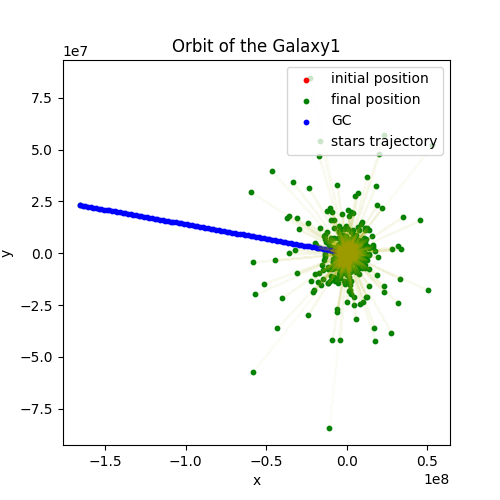

In [129]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(path[0,:,0], path[0,:,1], s=10, color='r', label='initial position', zorder=1)
plt.scatter(path[-1,:,0], path[-1,:,1], s=10, color='g', label='final position', zorder=1)
plt.scatter(path[:,0,0], path[:,0,1], s=10, color='b', label='GC', zorder=1)
plt.scatter(path[:,1:,0], path[:,1:,1], s=0.05, color='y', label='stars trajectory', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.show()
